## Building a Transformer Model

Using this famous paper: https://arxiv.org/pdf/1706.03762.pdf

The objective is to create this architechture

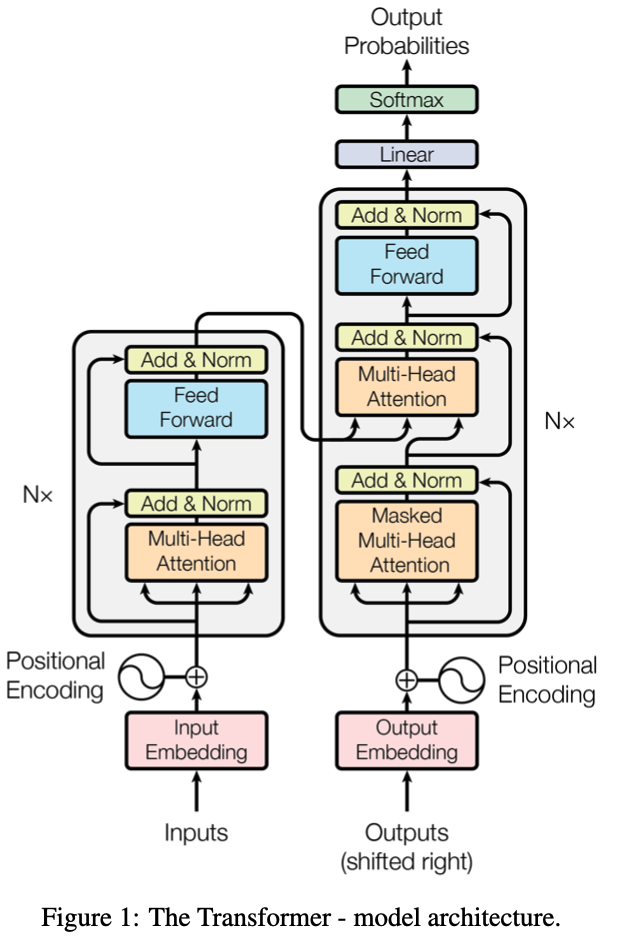

---

### Getting Data

Using the code from the data_analysis notebook.

In [286]:
import torch
from torch import nn
from torch.nn import functional as F

torch.manual_seed(3791)

with open('the_lord_of_the_rings.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)

# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

batch_size = 4 # Number independant sequences of tokens we will process in parrallel
block_size = 8 # Maximum context length for predictions

def get_batch(data):
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y 

print(decode(train_data[0:97].tolist()))


Three Rings for the Elven-kings under the sky,
Seven for the Dwarf-lords in their halls of stone,


The goal now that we have the data pulled in is to train a model to do text generation. The more techincal terminology for that is "next token prediction" meaning that the model will be able to look at what has come before and predict the character that will come next (More advanced models use words and peices of words but I am starting small)

<br>

---

### Embedding Table

The first peice of token prediction is to build a model that has the ability to record relationships between characters. We do this with a technology called the embedding table.

In [287]:
test_embedding = nn.Embedding(5, 5) # Random Embedding Table

for i in range(5):
    print(test_embedding(torch.tensor([i]))) # Retrieve Embedding

tensor([[-0.1155,  1.4004, -0.2636,  1.1846,  1.2524]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-1.4922, -0.8670,  0.4435, -0.1523, -0.1565]],
       grad_fn=<EmbeddingBackward0>)
tensor([[ 2.0149, -0.8710, -2.7495, -0.6273,  1.1433]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-2.1470, -0.3158, -0.1867,  0.9230, -0.7335]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-0.3809,  0.5600,  0.5015, -0.4943, -0.1860]],
       grad_fn=<EmbeddingBackward0>)


The embedding table is initialised with random weights that we are going to use to represent the probability of the character following the given token. 

You can call the values by "querying" the table for particular tensor. See above we ar calling with tensors [0], ... , [4] and getting the embedding tensor for each. This can also be done with a tensor of 2 dimensions to get multiple embedding tensors at once.

In [288]:
test_embedding(torch.tensor([[0], [1]]))

tensor([[[-0.1155,  1.4004, -0.2636,  1.1846,  1.2524]],

        [[-1.4922, -0.8670,  0.4435, -0.1523, -0.1565]]],
       grad_fn=<EmbeddingBackward0>)

See how with a 2x1 tensor we can call two embeddings. Thus we initialise our Bigram model with an embedding table.

In [289]:
class ExampleModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

model = ExampleModel(len(chars))
model.token_embedding_table(torch.tensor([0]))

tensor([[ 0.3442,  0.9577, -1.5105, -0.7749,  1.5252,  0.0909,  1.3469, -1.0264,
          0.6776, -0.5857,  0.3100,  0.0233, -0.5239,  0.6879, -0.3648,  0.4165,
         -0.3287, -0.3444,  0.9801, -0.6908,  0.1500, -0.8831,  0.0321,  0.4171,
          1.5222, -1.0674, -2.5141,  1.4262,  0.2582, -0.2657,  0.1911, -0.2096,
         -0.7396, -2.1908, -0.6412, -1.1399,  0.1989,  0.8807,  0.8749,  0.3764,
         -0.5525, -0.1188, -2.8033, -0.0061, -0.1929, -0.7781,  0.4275,  0.3869,
          0.0706,  0.7951, -0.9089,  0.0388,  0.7651,  1.5423, -0.4594, -0.0235,
         -0.9733,  0.7214, -1.3250,  2.0763,  0.0715,  0.3666, -0.6466, -0.2776,
         -1.4404, -0.2502, -0.5102,  1.1611, -0.1681,  0.9898,  1.9253,  0.6869,
          1.2430,  1.3106, -1.3647, -0.9620, -0.2909, -0.3432, -0.0999,  1.4572,
         -1.6297,  0.9408, -0.9184, -0.1979, -0.4507,  0.5716, -0.4538, -1.4719,
          0.8885,  0.6764]], grad_fn=<EmbeddingBackward0>)

This is the intialised embedding of the first char "\n". So the print out above is displaying the probabilities that the token will come after \n. So, for example the probability that \n will followin \n is -0.0876 in the 0th index of the tensor. Remember these are randomised so that isn't actually true but that is what the Embedding table is representing.

---

### Forward

All Neural Network models require a feed forward process to be defined. This will require that we make a prediction, and calulate the loss of that prediction vs the target.

In [290]:
xb, yb = get_batch(train_data)
print(xb[0])
print(decode(xb[0].tolist()))
print()
print(yb[0])
print(decode(yb[0].tolist()))

tensor([54, 57, 57, 66,  1, 73, 66, 53])
been una

tensor([57, 57, 66,  1, 73, 66, 53, 54])
een unab


As you can see from above, the first example in the batch has the input (idx) as the set of chars and then the target is shifted one along.

In [291]:
prediction = model.token_embedding_table(xb[0]) 
prediction.shape

torch.Size([8, 90])

So the model has used the existing weights to make a prediction. All it has done is call the embeddings of each on the 8 chars in the input. This returns 8 1x90 tensors giving the weights of the prediction that the next char will be each of the chars in the vocab list.

We can call for the whole batch together to parallelise the prediction.

In [292]:
multi_prediction = model.token_embedding_table(xb) 
multi_prediction.shape

torch.Size([4, 8, 90])

This gets us a (Number of Batches)x(Size of Batch)x(Vocab Size) tensor.

The naming convetion of this is logits which is a Batch x Time x Channel tensor.

Once, we have this prediction we need to calculated the loss between the logits and the targets using cross entropy. 

In [293]:
logits = model.token_embedding_table(xb) 
print(logits.shape)
print(yb.shape)

torch.Size([4, 8, 90])
torch.Size([4, 8])


But to do this we need to rearrange both tensors.

In [294]:
targets = yb
logits = model.token_embedding_table(xb) 
B, T, C = logits.shape

try:
    loss = F.cross_entropy(logits, targets)
except Exception as e:
    print("logits", logits.shape)
    print("targets", targets.shape)
    print(e)

print("-- Reshape --")
logits = logits.view(B*T, C)
targets = targets.view(B*T)

loss = F.cross_entropy(logits, targets)
print(logits.shape)
print(targets.shape)
print(loss)
print("loss:", loss.tolist())

logits torch.Size([4, 8, 90])
targets torch.Size([4, 8])
Expected target size [4, 90], got [4, 8]
-- Reshape --
torch.Size([32, 90])
torch.Size([32])
tensor(4.9346, grad_fn=<NllLossBackward0>)
loss: 4.934645175933838


Combing the batches into a single dimension 8x4 -> 32 allows the loss function to work on the whole channel. The for each of the 32 individual samples the loss is calculated and aggregated to a single value.

We can now add this as the forward method of the model.

In [295]:
class ExampleModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # Batch x Time x Channel, tensor prediction of what is next
        logits = self.token_embedding_table(idx) 

        if targets is None: # For predictions where there is no target i.e just generating.
            loss = None
        else:
            # Based on the PyTorch docs we need a B*C x T tensor to calcualate loss
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits , loss 

In [296]:
model = ExampleModel(len(chars))
inputs, targets = get_batch(train_data)

model(inputs, targets)

(tensor([[-0.3723,  0.7553, -0.0116,  ..., -0.4122, -0.1359, -0.3183],
         [-0.3925,  0.4913, -2.0963,  ...,  1.0126, -1.3088, -0.5255],
         [ 1.2102, -0.1006, -0.5687,  ..., -2.1167,  1.5608,  1.4984],
         ...,
         [ 0.3954, -1.8654, -0.9106,  ..., -1.1071, -0.4496,  0.5957],
         [-0.5680,  0.4464, -0.1636,  ..., -1.0656,  0.9717, -1.5425],
         [ 1.0697,  0.4621,  1.1798,  ..., -0.8339, -1.6184, -0.7691]],
        grad_fn=<ViewBackward0>),
 tensor(4.7117, grad_fn=<NllLossBackward0>))


---

### Generation

The next thing to add to the model is a method that askes it to generate text based on the current embedding weights. This will be very similar to the forward method but instead of calculating the loss we turn the logits into an output tensor.

Choosing a random token:

In [297]:
token_id = 26
decode([token_id])

'B'

So, can now just get the logits from the forward method.

In [298]:
idx = torch.tensor([[token_id]])
logits, loss = model(idx)
logits = logits[:, -1, :] 
logits


tensor([[ 1.1858e+00, -4.9327e-01, -1.9447e+00, -4.4081e-01,  2.6501e-03,
          5.3936e-01,  2.1330e-01, -7.1541e-01,  6.8131e-02, -7.1106e-01,
         -1.5422e+00,  1.6065e+00,  2.3858e+00, -5.6496e-01, -1.7900e+00,
          1.0732e+00,  1.5358e+00,  6.3908e-01, -4.0596e-01, -9.1557e-02,
          1.0003e+00, -3.2269e-01, -4.4188e-01, -3.2526e-01, -3.3579e-01,
          3.4698e-01, -1.4513e+00,  2.5231e-01, -3.1592e-01,  3.8024e-02,
         -1.2849e-01,  8.4887e-01,  1.3745e+00,  6.9393e-01, -1.0462e+00,
         -7.2398e-01,  1.3280e+00,  2.8721e-01, -5.1100e-01,  1.8616e-01,
         -5.2194e-01, -9.6673e-01,  9.4727e-01,  1.1304e+00, -1.0383e+00,
         -7.2330e-01, -5.5404e-01, -1.1394e+00,  3.7563e-01,  4.5904e-01,
          1.0331e+00, -2.4764e+00,  2.2267e+00,  1.4216e+00, -8.0848e-01,
         -1.3861e+00,  1.1532e+00, -2.0237e+00,  7.7194e-01,  5.5535e-01,
         -2.4234e-01, -8.2424e-01, -9.8410e-01, -8.4057e-01, -2.9957e-01,
         -3.8765e-01, -1.1245e+00,  8.

Now we can softmax to get the probabilty of each character.

In [299]:
probs = F.softmax(logits, dim=-1) 
probs

tensor([[0.0207, 0.0039, 0.0009, 0.0041, 0.0063, 0.0108, 0.0078, 0.0031, 0.0068,
         0.0031, 0.0014, 0.0315, 0.0687, 0.0036, 0.0011, 0.0185, 0.0294, 0.0120,
         0.0042, 0.0058, 0.0172, 0.0046, 0.0041, 0.0046, 0.0045, 0.0089, 0.0015,
         0.0081, 0.0046, 0.0066, 0.0056, 0.0148, 0.0250, 0.0127, 0.0022, 0.0031,
         0.0239, 0.0084, 0.0038, 0.0076, 0.0038, 0.0024, 0.0163, 0.0196, 0.0022,
         0.0031, 0.0036, 0.0020, 0.0092, 0.0100, 0.0178, 0.0005, 0.0586, 0.0262,
         0.0028, 0.0016, 0.0200, 0.0008, 0.0137, 0.0110, 0.0050, 0.0028, 0.0024,
         0.0027, 0.0047, 0.0043, 0.0021, 0.0151, 0.0283, 0.0142, 0.0047, 0.0071,
         0.0014, 0.0147, 0.0144, 0.0063, 0.0044, 0.0013, 0.0041, 0.0586, 0.0095,
         0.0069, 0.0057, 0.0046, 0.0088, 0.0033, 0.1081, 0.0037, 0.0039, 0.0067]],
       grad_fn=<SoftmaxBackward0>)

We can the sample 1 tensor based on the multinomial distribtion across the probabilities.

In [300]:
torch.multinomial(probs, num_samples=1)

tensor([[12]])

It will help to demonstrate how this works graphically by running multinomial 10000 times and plotting the results.

In [301]:
results_dict = {i: 0 for i in range(0, 90)}
for _ in range(10000):
    result = torch.multinomial(probs, num_samples=1)
    results_dict[result[0].tolist()[0]] += 1

In [302]:
prob_dict = {}
for i, prob in enumerate(probs[0].tolist()):
    prob_dict[i] = prob

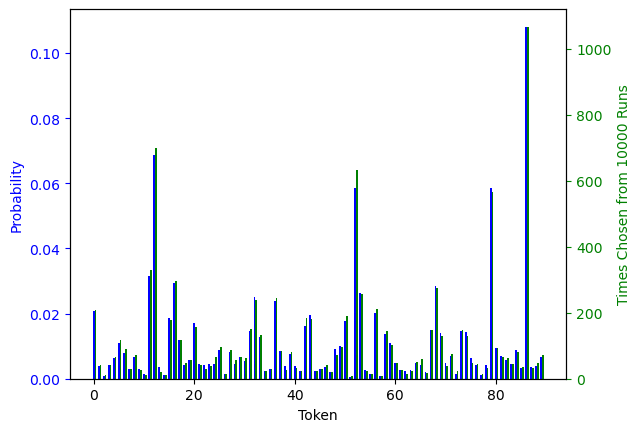

In [303]:
import matplotlib.pyplot as plt
import numpy as np

keys = list(prob_dict.keys())
values1 = list(prob_dict.values())
values2 = list(results_dict.values())

bar_width = 0.35

r1 = np.arange(len(keys))
r2 = [x + bar_width for x in r1]

fig, ax1 = plt.subplots()

ax1.bar(r1, values1, width=bar_width, label='Dataset 1', color='b')
ax1.set_xlabel('Token')
ax1.set_ylabel('Probability', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.bar(r2, values2, width=bar_width, label='Dataset 2', color='g')
ax2.set_ylabel('Times Chosen from 10000 Runs', color='g')
ax2.tick_params('y', colors='g')

plt.show()


See how the probability and rate of selection relate to one another.

Finally we can piece this all together.

In [304]:
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size) -> None:
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx) 

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits , loss 
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] 
            probs = F.softmax(logits, dim=-1) 
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
m = BigramLanguageModel(len(chars)) 

print("Batch:", decode(xb[0].tolist()))
gen = m.generate(xb, 5)
print("Generation:", decode(gen[0].tolist()))


Batch: been una
Generation: been una9pA=5


So, it works. We just need to train it.

---

### Training Loop

The training loop is very simple at this stage. The only additional componant we need is an optimizer which controls the progressive small steps towards the optimum (lowest, in this case) loss.  

In [305]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

With that we can step through the simple loop:

For a given number of steps:
- Get a batch of the training data
- Predict the next token
- Calculate the loss
- Take a step in a direction towards the lower loss. 

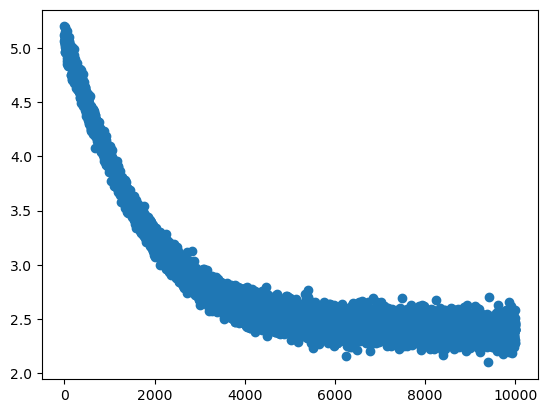

In [306]:
batch_size = 32
number_of_steps = 10000
losses = []

for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)          # Getting batch of training data.
    logits, loss = m(xb, yb)                # Predict next token and calculate loss.

    optimizer.zero_grad(set_to_none=True)   
    loss.backward()                         # Back propagate the loss.
    optimizer.step()                        # Adjust the optimizer.

    losses.append(loss.item())              # Storing losses to plot.

plt.scatter(range(0, 10000), losses)

This does pretty well and should reflect in the improved generation.

In [307]:
print("Batch:", decode(xb[0].tolist()))
gen = m.generate(xb, 15)
print("Generation:", decode(gen[0].tolist()))

Batch: ' grandm
Generation: ' grandm bor: y balodin


It's not Tolkien but it does seem to understand the english language better now.

In [308]:
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Number of Parameters: 8100


So, far we have accomplished the following 2 peices with a single Neural Network module in between:

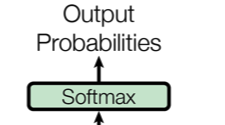

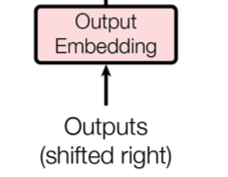

Our module has a simple embedding of 90x90 = 8100 parameters. To improve the performance we need to add attenetion

---

### Token and Positional Embedding Tables

To be able to build up a more complex Neural net we need to understand the token and positional embedding tables

In [309]:
n_embd = 16 # This will be fixed for the rest of the notebook

token_embedding_table = nn.Embedding(vocab_size, n_embd)
position_embedding_table = nn.Embedding(block_size, n_embd)

Similar to our embedding table earlier the idea is to record a relationship of the tokens and the positions. But this time it is more abstracted as we are not just comparing each of the tokens to the indiviual token before but instead we record the relationship with of the token with a selected abstract "number of embeddings" and likewise we record the position by embedding the location of the token in the the block with the number of embeddings.

In [310]:
xb, yb = get_batch(train_data)
B, T = xb.shape
print("B:", B)
print("T:", T)
print()
token_embedding = token_embedding_table(xb)
position_embedding = position_embedding_table(torch.arange(T))
print(token_embedding.shape)
print()
print(position_embedding.shape)

B: 32
T: 8

torch.Size([32, 8, 16])

torch.Size([8, 16])


So, as shown above a batch of 4 blocks of 8 tokens is input into the token embedding table and for each token in each batch there are 16 embeddings given. Likewise for each block there are 16 positional, embeddings returned. Remember the number of embeddings is chose by us and the more embeddings means the more params in our model.

In [311]:
x = token_embedding + position_embedding
x.shape

torch.Size([32, 8, 16])

Now adding these together combines a posistional embedding with a token embedding thus giving us our logits for the xb batch representing the relationship of the token to it's position and the embeddings.

In [312]:
linear_example = nn.Linear(n_embd, vocab_size)
linear_example(x).shape

torch.Size([32, 8, 90])

To reshape the tensor into a input to token mapping tensor we then need to add the linear part of the transformer:

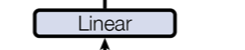

Thus, changing this embedding into a BlockxBatch -> Token mapping tensor i.e. (BxTxvocab_size)


In [313]:
import logging

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

class ModelWithPosition(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        logger.debug(f"idx shape: {idx.shape}")
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        logger.debug(f"tok_emb shape: {tok_emb.shape}")
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        logger.debug(f"pos_emb shape: {pos_emb.shape}")
        x = tok_emb + pos_emb # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        logger.debug(f"logits shape: {logits.shape}")

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            logger.debug(f"logits view shape: {logits.shape}")
            
        return logits, loss
    
m = ModelWithPosition()
logits, loss = m(xb)

print("Input:", xb.shape)
print("Logits:", logits.shape)
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Input: torch.Size([32, 8])
Logits: torch.Size([32, 8, 90])
Number of Parameters: 3098


The parametes here are made up by the dimension of the token embeddings table plus the position embeddings table. Then, a linear transformation gets applied to convert the tensor to the correct dimensions.

In [314]:
n_embd * vocab_size + \
n_embd * block_size + \
(n_embd + 1) * vocab_size

3098

The 1 comes from the bias which is the additional vector of vocab_sizex1 added in the linear transformation.

In [315]:
class ModelWithoutBias(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)

    
m = ModelWithoutBias()
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Number of Parameters: 3008


In [316]:
logger.setLevel(logging.DEBUG)

m = ModelWithPosition()

idx = xb
logits, loss = m(xb)
logits = logits[:, -1, :] 
print()
print("Logits:", logits.shape)
probs = F.softmax(logits, dim=-1) 
print("Probs:", probs.shape)
idx_next = torch.multinomial(probs, num_samples=1)
print("idx Next:", idx_next.shape)
idx = torch.cat((idx, idx_next), dim=1)
print("idx:", idx.shape)
print()
print("Batch:", decode(xb[0].tolist()))
print("Generation:", decode(idx[0].tolist()))

DEBUG:root:idx shape: torch.Size([32, 8])
DEBUG:root:tok_emb shape: torch.Size([32, 8, 16])
DEBUG:root:pos_emb shape: torch.Size([8, 16])
DEBUG:root:logits shape: torch.Size([32, 8, 90])



Logits: torch.Size([32, 90])
Probs: torch.Size([32, 90])
idx Next: torch.Size([32, 1])
idx: torch.Size([32, 9])

Batch:  not. It
Generation:  not. Ity


As demonstrated here, the batch of 4 blocks of 8 tokens is passed to the function.

Then, each of the tokens in each of the blocks is embedded into the 16 embeddings.

Next, each of the positions is embedded into the 16 embeddings. Notice here that since the positions are the same for each block in the batch, the embedding only needs to be 8x16. 

Then the position and token embeddings are added together and after the linear transformation we have a logits tensor that has the weights for each position in each block with the probability for each token in the vocab list (90).

Then we can turn that into a prediction by taking the last (8th) position for each batch which are the logits and the top probability of the 90 tokens to get the 4x1 tensor that tells us the id of the next token.

Then we can concat the batch with the next token to get the next predicted value.

Thus we have generated a prediction using the position in the string and the token value.

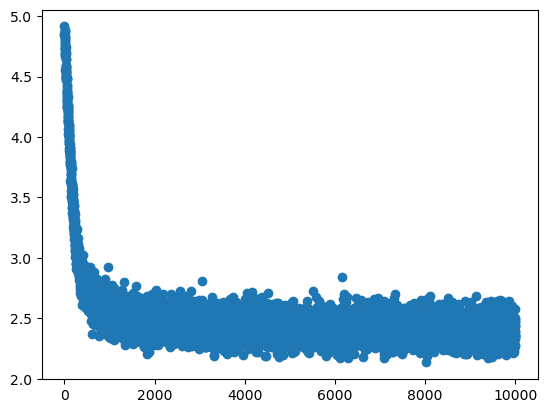

In [317]:
logger.setLevel(logging.INFO)

m = ModelWithPosition()
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

batch_size = 32
number_of_steps = 10000
losses = []

for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)          # Getting batch of training data.
    logits, loss = m(xb, yb)                # Predict next token and calculate loss.

    optimizer.zero_grad(set_to_none=True)   
    loss.backward()                         # Back propagate the loss.
    optimizer.step()                        # Adjust the optimizer.

    losses.append(loss.item())              # Storing losses to plot.

plt.scatter(range(0, 10000), losses)

As you can see we reach the optimum faster using this method but the actual results aren't drastically improved. We will need to have a more data dependant approach to improve the results where we are not just looking for the token and it's position but for each token we build up a relationship to each other token based on the positions and the position in the string.

For this we need self attention.

---

### Single Head of Self-attention

In our current model the token and position in the block are being encoded. This is a good start but the model is not training based on the data around the token. A given token would need to have some way of learning based on the values of the tokens around them not just the token itself and the position in the block. This is why we introduce self-attention.

Self-attention involves the initialisation of Linear embeddings that contain the key (the content of the position) and the query (what the position is looking for). To get the probabilities we dot product the key and query

In [328]:
head_size = 4
key = nn.Linear(n_embd, head_size, bias=False)
query = nn.Linear(n_embd, head_size, bias=False)

k = key(x) # B, T, head_size
q = query(x) # B, T, head_size

wei = q @ k.transpose(-2,-1) # Transpose the last 2 dimensions. So (B, T, 16) @ (B, 16, T) ---> (B, T, T)

print("k shape:", k.shape)
print("q shape:", q.shape)
print("wei shape:", wei.shape)

k shape: torch.Size([32, 8, 4])
q shape: torch.Size([32, 8, 4])
wei shape: torch.Size([32, 8, 8])


Now for every batch B we have a T squared matrix giving the affinities bewteen the keys and the queries.

Then we can create a matrix with ones in a triangular pattern. This will seperate out each array of tokens. So with an input:

        Hello World!

We will look at:

        H
        He
        Hel
        Hell
        Hello
        Hello 
        Hello W

Etc

In [319]:
tril = torch.tril(torch.ones(T, T))
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

Applying this to our example we can see for the first batch the triangulated matrix of affinites 

In [320]:
wei = wei.masked_fill(tril == 0, float('-inf'))
wei[0]

tensor([[-1.2684,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-2.5677,  2.0085,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 1.9442, -1.9027, -1.1733,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.4485,  0.4154,  0.2866, -0.2152,    -inf,    -inf,    -inf,    -inf],
        [ 0.4450, -0.2888, -0.3674, -0.1880,  0.2429,    -inf,    -inf,    -inf],
        [-1.8580,  1.9635,  1.0234, -1.6825, -0.8720, -1.4378,    -inf,    -inf],
        [-1.7098,  1.4177,  1.2041, -0.2808, -0.8755, -0.0577,  0.8425,    -inf],
        [ 0.8595, -0.6033, -0.6789, -0.2148,  0.4606, -0.3263, -0.7454, -0.5179]],
       grad_fn=<SelectBackward0>)

The only issue with this is the high variance of output weights.

In [321]:
wei = q @ k.transpose(-2,-1)
wei.var()

tensor(1.3986, grad_fn=<VarBackward0>)

We fix this with a normailsation step.

In [322]:
wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
wei.var()

tensor(0.6993, grad_fn=<VarBackward0>)

Then as before we can softmax and get the output.

In [323]:
wei = F.softmax(wei, dim=1)
out = wei @ x
out.shape # B, T, C

torch.Size([32, 8, 16])

We now have a data dependant representation where, for each token and position embedding, we have a key, query and value. 

The key is a representation of the content of that embedding, the query represents what that embedding is looking for and the value is the value of the embedding. 

Taking the key and dot producting with the query will give us the affinities beween the content and the embeddings being search for. Then the matrix multiplication with the values will add a further amplifier. 

This will give outputs that say, for this token and position embedding in the string, this other token and position embedding has a high (or low) affinity and we value this with a weight of x. Thus giving the probability that the next token will be y.

Then using softmax we get the prediction for each token embedding.

In [338]:
logger.setLevel(logging.DEBUG)
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

m = Head(head_size)
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Number of Parameters: 768


Let's create a model with this Head module.

In [339]:
class ModelWithSelfAttention(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.head = Head(head_size)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        logger.debug(f"idx shape: {idx.shape}")
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        logger.debug(f"tok_emb shape: {tok_emb.shape}")
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        logger.debug(f"pos_emb shape: {pos_emb.shape}")
        x = tok_emb + pos_emb # (B,T,C)
        x = self.head(x)
        logger.debug(f"x shape: {x.shape}")
        logits = self.lm_head(x) # (B,T,vocab_size)
        logger.debug(f"logits shape: {logits.shape}")

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            logger.debug(f"logits view shape: {logits.shape}")
            
        return logits, loss
    
head_size = 16
xb, yb = get_batch(train_data)
m = ModelWithSelfAttention(head_size)
logits, loss = m(xb)

print("Input:", xb.shape)
print("Logits:", logits.shape)
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

DEBUG:root:idx shape: torch.Size([32, 8])
DEBUG:root:tok_emb shape: torch.Size([32, 8, 16])
DEBUG:root:pos_emb shape: torch.Size([8, 16])
DEBUG:root:x shape: torch.Size([32, 8, 16])
DEBUG:root:logits shape: torch.Size([32, 8, 90])


Input: torch.Size([32, 8])
Logits: torch.Size([32, 8, 90])
Number of Parameters: 3866


So, now it should make sense that we are doing the same thing but instead of a simple linear transformation we are adding in more complexity into the repersentation of the token in the model and each time we get the logits to predict the next tokens and compare with the true next tokens.

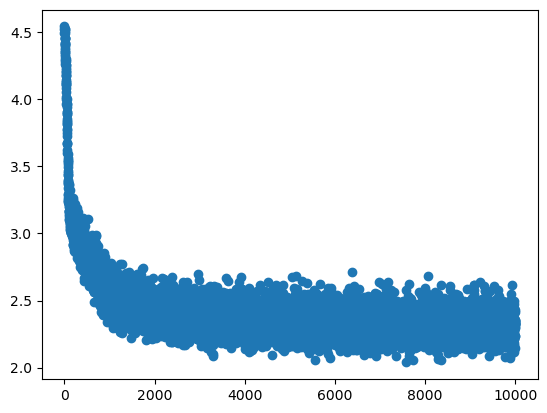

In [334]:
logger.setLevel(logging.INFO)

m = ModelWithSelfAttention()
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

batch_size = 32
number_of_steps = 10000
losses = []

for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)          # Getting batch of training data.
    logits, loss = m(xb, yb)                # Predict next token and calculate loss.

    optimizer.zero_grad(set_to_none=True)   
    loss.backward()                         # Back propagate the loss.
    optimizer.step()                        # Adjust the optimizer.

    losses.append(loss.item())              # Storing losses to plot.

plt.scatter(range(0, 10000), losses)

As you can see this doesn't make much difference but it becomes much more powerful if we continue to add Heads of attention. We are now going to create a transformed block with multiple heads of self attention.

---


### Transformer Block

With Multi-head attention in place we can look at finally combining the sections up to now into a full transformer block. Let's remind ourselves of what we are trying to recreate.

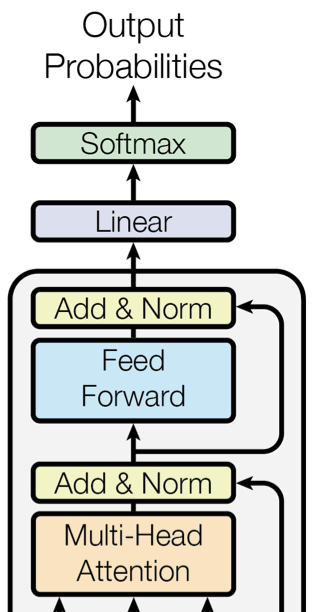

The simplestv possible version of this is below. We tell the Block the number of embeddings and number of heads. We then create a multi head attention module and add a forward method conisisting of a LayerNorm passed into a 

In [343]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return out

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        logger.debug(f"head_size: {head_size}")
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)

    def forward(self, x):
        logger.debug(f"x shape: {x.shape}")
        logger.debug(f"x shape: {self.ln1(x).shape}")
        x = x + self.sa(self.ln1(x))
        return x
    
class ModelWithSimpleTransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = Block(n_embd, n_head)
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        logger.debug(f"idx shape: {idx.shape}")
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        logger.debug(f"tok_emb shape: {tok_emb.shape}")
        pos_emb = self.position_embedding_table(torch.arange(T)) # (T,C)
        logger.debug(f"pos_emb shape: {pos_emb.shape}")
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x)
        logger.debug(f"x shape: {x.shape}")
        logits = self.lm_head(x) # (B,T,vocab_size)
        logger.debug(f"logits shape: {logits.shape}")

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            logger.debug(f"logits view shape: {logits.shape}")
            
        return logits, loss
    
n_head = 4
logger.setLevel(logging.DEBUG)

xb, yb = get_batch(train_data)
m = ModelWithSimpleTransformerBlock()
logits, loss = m(xb)

print("Input:", xb.shape)
print("Logits:", logits.shape)
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

DEBUG:root:head_size: 4
DEBUG:root:idx shape: torch.Size([32, 8])
DEBUG:root:tok_emb shape: torch.Size([32, 8, 16])
DEBUG:root:pos_emb shape: torch.Size([8, 16])
DEBUG:root:x shape: torch.Size([32, 8, 16])
DEBUG:root:x shape: torch.Size([32, 8, 16])
DEBUG:root:x shape: torch.Size([32, 8, 16])
DEBUG:root:logits shape: torch.Size([32, 8, 90])


Input: torch.Size([32, 8])
Logits: torch.Size([32, 8, 90])
Number of Parameters: 3930


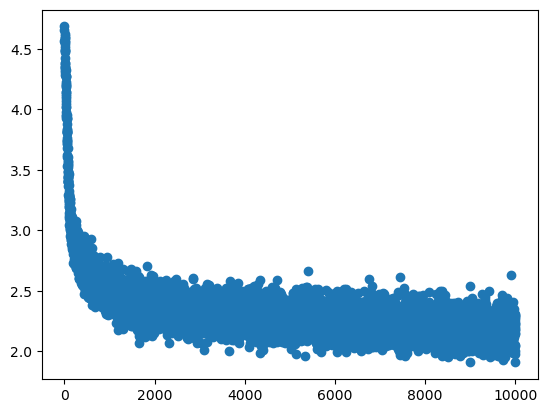

In [344]:
logger.setLevel(logging.INFO)

m = ModelWithSimpleTransformerBlock()
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

batch_size = 32
number_of_steps = 10000
losses = []

for steps in range(number_of_steps):
    xb, yb = get_batch(train_data)          # Getting batch of training data.
    logits, loss = m(xb, yb)                # Predict next token and calculate loss.

    optimizer.zero_grad(set_to_none=True)   
    loss.backward()                         # Back propagate the loss.
    optimizer.step()                        # Adjust the optimizer.

    losses.append(loss.item())              # Storing losses to plot.

plt.scatter(range(0, 10000), losses)

---

### Many More Heads

From now on the parameter's are going get very numerous so I'm going to use my M2 chip on my Mac.

In [356]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)

The main addition here is I am introducing the idea of having multiple sequential blocks of Multi-Head self attention to increase the complexity of the model further.

In [363]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [366]:
n_layer = 6 

class MultiBlockModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

m = MultiBlockModel()
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Number of Parameters: 7898


INFO:root:Step: 0
INFO:root:Step: 500
INFO:root:Step: 1000
INFO:root:Step: 1500
INFO:root:Step: 2000
INFO:root:Step: 2500
INFO:root:Step: 3000
INFO:root:Step: 3500
INFO:root:Step: 4000
INFO:root:Step: 4500
INFO:root:Step: 5000
INFO:root:Step: 5500
INFO:root:Step: 6000
INFO:root:Step: 6500
INFO:root:Step: 7000
INFO:root:Step: 7500
INFO:root:Step: 8000
INFO:root:Step: 8500
INFO:root:Step: 9000
INFO:root:Step: 9500


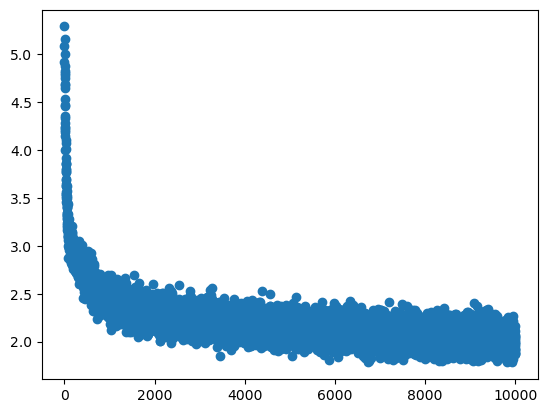

In [367]:
batch_size = 32
number_of_steps = 10000
losses = []
m = MultiBlockModel()
m.to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
m.train()

for steps in range(number_of_steps):
    if steps % 500 == 0:
        logger.info(f"Step: {steps}")
    xb, yb = get_batch(train_data)

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

plt.scatter(range(0, 10000), losses)

---

### A Couple More Bells and Whistles

1. Dropout: Turns neurons in the network on and off randomly.
2. ReLU: Solves the vainishing gradient problem.
3. Normalization: Removes varience from the steps in the network.
4. Better weight initialisation.

In [368]:
dropout = 0.2

In [372]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    
m = GPTLanguageModel()
print("Number of Parameters:", sum(p.numel() for p in m.parameters()))

Number of Parameters: 22522


INFO:root:Step: 0
INFO:root:Step: 500
INFO:root:Step: 1000
INFO:root:Step: 1500
INFO:root:Step: 2000
INFO:root:Step: 2500
INFO:root:Step: 3000
INFO:root:Step: 3500
INFO:root:Step: 4000
INFO:root:Step: 4500
INFO:root:Step: 5000
INFO:root:Step: 5500
INFO:root:Step: 6000
INFO:root:Step: 6500
INFO:root:Step: 7000
INFO:root:Step: 7500
INFO:root:Step: 8000
INFO:root:Step: 8500
INFO:root:Step: 9000
INFO:root:Step: 9500


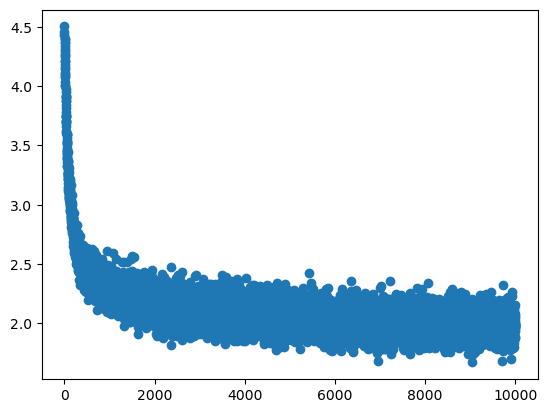

In [373]:
batch_size = 32
number_of_steps = 10000
losses = []
m = GPTLanguageModel()
m.to(device)
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)
m.train()

for steps in range(number_of_steps):
    if steps % 500 == 0:
        logger.info(f"Step: {steps}")
    xb, yb = get_batch(train_data)

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

plt.scatter(range(0, 10000), losses)

In [376]:
def generate_text(model, text_length):
    model.eval()
    # generate from the model
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    return decode(model.generate(context, max_new_tokens=text_length)[0].tolist())

print(generate_text(m, 1000))


' seack a as the lipppeen in the theret long of Ley and the boat that ou wold hy! But to banw had' leclown ourg forlyins again were into shill pasts of hader it boat and on was just for it SouComish of lohier.
`Noand the do? ' 
Lagie-on alver. 'He but bis of Gelmured.
'Here Low spalp hard Westrung is lages! Too shilve arow up Aragainel, now Eldned. ' Fat it beam. Thriste uf hame grot den bout to firsed, now the to come would. What and nhark away lower all nigf.
`Frodo saet courth. They, Law wach dast his even he lon that de they acaint mon ow lasck coures wover sas a the Ased a? '
'
Cor, Fre's damed falow whoat plodys anlown wham af and leink wiwarlied of Galadled, herd woww the grean: what is the shelen flaswarded and alf and the shar narendlo Golf suir comined I the romen_ go no
Fe mireftrestelly. Ladwerë; and wall; the kand. As though fir is the Sasth my of the callagainy the thiche That dell Galwall fay eevers Tinl son-ugh to thy end waching of bir a glet in a's more of that and o